In [1]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import numpy as np
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from torch import nn, optim
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis import plot
from toy_cis.models import CisConfig, Cis
from toy_cis.util import threshold_matrix


In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
"""Create functions for generating batches, loss, and training."""

# Create function for generating batch of `x` and `y_true` data
def gen_batch(model: Cis, batch_sz: int) -> (
    tuple[Float[t.Tensor, "batch inst feat"], Float[t.Tensor, "batch inst feat"]]
):
    """Generates a batch of x=(sparse feature vals on [-1, 1]) and y=abs(x)."""

    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat) * 2 - 1  # [-1, 1]
    is_active = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat) < (1 - model.s)
    x *= is_active
    return x, F.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz)
        y = model.forward(x)
        loss = loss_fn(y, y_true, model.i)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

## Simple-ReLU

Target: 
$$
y = ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h + b
$$

In [4]:
"""Create model."""

layer_act_fns = [F.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=40,
    act_fn=layer_act_fns,
    b1="0",
    b2=0.0,
    feat_sparsity=0.99
)

simple_relu_model = Cis(simple_relu_cfg)

In [5]:
"""Train model."""

batch_sz = 512
n_steps = 2000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(simple_relu_model.parameters())

train(simple_relu_model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

[0.0017477761721238494,
 0.0009306418360210955,
 0.0009632906876504421,
 0.0011757187312468886,
 0.0009451751247979701,
 0.0010717703262344003,
 0.0009440322173759341,
 0.0010214174399152398,
 0.0009833996882662177,
 0.0010526935802772641,
 0.0011665103957057]

In [7]:
simple_relu_model.W1.shape

torch.Size([1, 100, 40])

In [17]:
# Element wise multiplication of l1_weights and l2_weights
l1_weights = threshold_matrix(asnumpy(simple_relu_model.W1).squeeze(), threshold=0.05)
l2_weights = threshold_matrix(asnumpy(simple_relu_model.W2).squeeze(), threshold=0.05)
l1_weights = (l1_weights.T * l2_weights).T

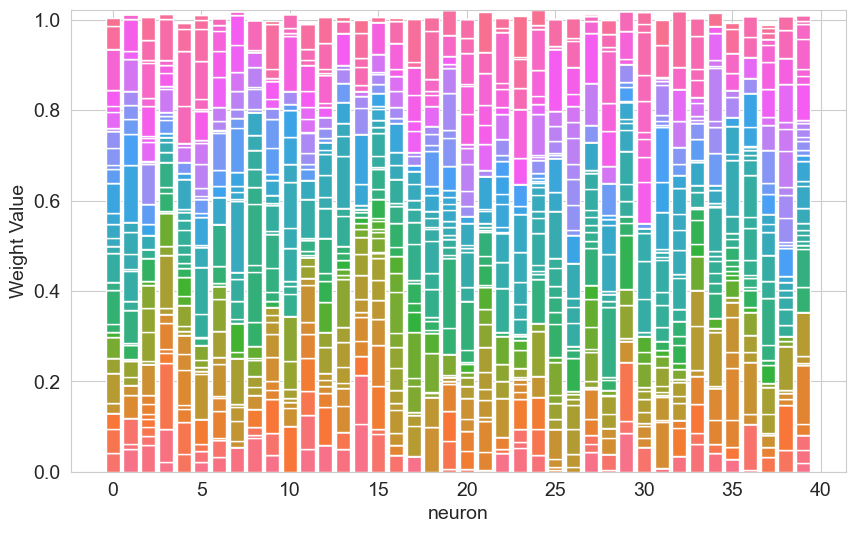

In [24]:
plt.rcParams.update({'font.size': 14})  # Set base font size
fig = plot.plot_weight_bars(l1_weights, xax="neuron")

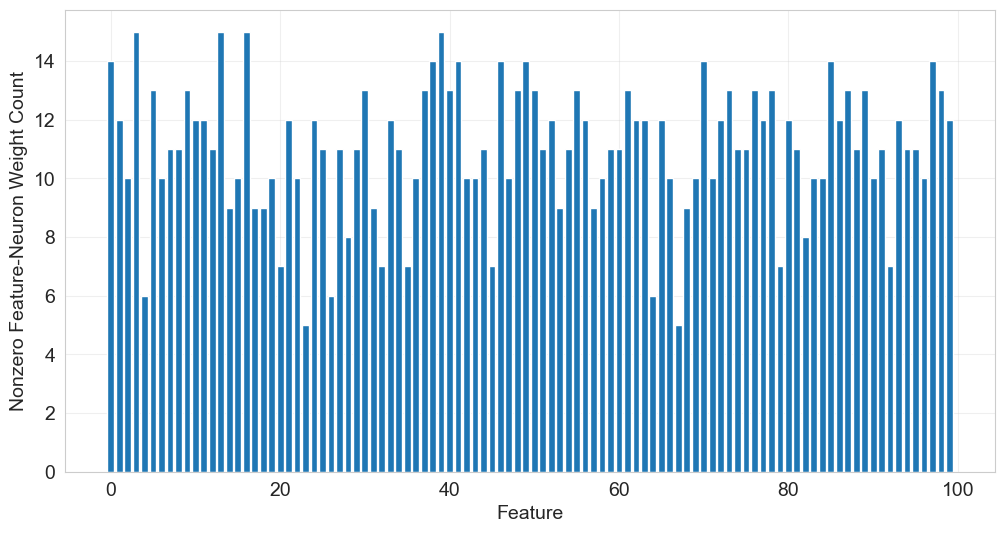

In [16]:
nonzero_counts = np.count_nonzero(l1_weights.T, axis=0)  # axis=0 counts along first dimension

# Using matplotlib
plt.rcParams.update({'font.size': 14})  # Set base font size
plt.figure(figsize=(12, 6))
plt.bar(range(len(nonzero_counts.T)), nonzero_counts.T)
plt.xlabel('Feature')
plt.ylabel('Nonzero Feature-Neuron Weight Count')
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
np.mean(nonzero_counts)

np.float64(10.99)